# Introduzione

Questo è il jupyter notebook dell'esperienza no. 2 del corso di laboratorio di Fisica III.

All'inizio inizializzo le librerie che mi servono per fare l'analisi dati:

- `numpy`, rinominato `np` è la libreria che gestisce matrici, array
- `pandas`, rinominato `pd`, è la libreria che ci permette di importare i dati in delle tabelle chiamate **DataFrame**, che sono estremamente più potenti delle normali tabelle. Permette di fare operazioni di massa sui dati in modo estremamente selettivo, e addirittura permette di mettere indici multipli
- `scipy` è la collezione di librerie che contiene tante cose per trattare segnali, fare fit generalizzati, eccetera
- `pyplot` sotto `matplotlib` è un potente strumento che permette di plottare curve e funzioni
- `math` contiene costanti universali

In seguito vedete delle definizioni di funzioni simboliche: queste ci permettono dopo di inserirle direttamente nei fitting.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy import signal, constants
import math

# Define fitting functions
def expf(x, a, b, c):
    return a*np.exp(-b*x)+c
def linf(x, m, q):
    return m * x + q
def hpbf(rl, z0):
    return (rl+z0)/(rl-z0)

pd.set_option('display.float_format', lambda x: '%.7E' % x)
from matplotlib.backends.backend_pdf import PdfPages

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
def find_nearest_id(array, value):
    #array = np.asarray(array)
    idx = (np.abs(array - value)).idxmin()
    return idx

In [2]:
# La funzione chiq prende come parametri i valori teorici, le osservazioni, e gli errori sulle osservazioni
def chiq(exp, obs, obsErr):
    return sum(np.power((exp - obs), 2) / np.power(obsErr, 2))

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

# La funzione testchiq prende come parametri i gradi di libertà, quantile inf, quantile sup e valore del chi quadro
def testchiq(degf, infq, supq, valchiq):
    infchiq = chi2.isf(
        q=1 - infq, df=degf)
    supchiq = chi2.isf(
        q=1 - supq, df=degf)
    print('Chi quadrato per modello e osservazioni: %f.' % valchiq)
    print(
        'Studiamo se il chi quadro è nel range [%f, %f]' % (infchiq, supchiq))
    if (valchiq <= supchiq) & (valchiq >= infchiq):
        print(color.BOLD + color.GREEN + 'Test del chi quadro superato!' +
              color.END + color.END)
    else:
        print(color.BOLD + color.RED + 'Test del chi quadro non superato!' +
              color.END + color.END)


# La funzione stattest prende come parametri valore 1, errore 1, valore 2, errore 2, e infine il fattore di copertura.
def stattest(val1, val2, err1, err2, kcop):
    R = abs(val1 - val2)
    errR = np.sqrt(err1**2 + err2**2)
    infconf = R - kcop * errR
    supconf = R + kcop * errR
    if (0 > infconf) & (0 < supconf):
        print(color.BOLD + color.GREEN +
              'Il test è superato con una confidenza di %.0f sigma!' % (kcop) +
              color.END + color.END)
    else:
        print(color.BOLD + color.RED +
              'Il test non è superato con un confidenza di %.0f sigma' %
              (kcop) + color.END + color.END)

## Analisi dati: Velocità luce

Qui inizializzo i vettori (vuoti) delle differenze di tempo e del gain, e degli errori di risoluzione rispettivi. Apro un ciclo sugli indici `i`, che si riferiscono alle coorti di dati riferite a una lunghezza specifica del cavo coassiale, e sugli indici `j`, che invece indicano catture diverse dello stesso segnale. Per ogni `i` estraggo la scala delle tensioni per calcolare l'errore di risoluzione `delta_V`, poi nel ciclo sui `j` leggo i file `csv`, li inserisco in un dataframe.

In seguito elimino la primissima riga, ed elimino le righe che contengono valori NaN (non definiti). Chiamo la funzione `find_peaks` che, data la coorte di dati (in funzione dell'indice del DataFrame) e una certa soglia `prominence`, mi individua i picchi più prominenti del segnale analizzato. La funzione sputa fuori gli indici a cui si trovano i picchi e alcune proprietà importanti del picco, come la base sinistra e la base destra (dato che utilizzeremo in seguito).

Ad esempio otteniamo qualcosa del genere:

![](example1.png)

In seguito definisco i tempi a cui rilevo il picco come `peak2` e `peak1`, e i "piedi" sinistri del picco come `side2` e `side1`. Infatti voglio trovare la differenza tra le metà delle rampe in ascesa come $\Delta t$. L'ambaradan alle definizioni significa che prendo, dalla colonna `'second'` del dataframe `df` l'elemento numero ad esempio `pk1[1]`, ovvero l'elemento numero due del vettore `pk1`.

Discorso simile avviene per il gain. Inutile discutere della definizione dell'errore, basta leggere. Ora però all'interno dei due cicli ho definito quattro vettori da sedici elementi, vorrei però distinguere le quattro coorti di dati con quattro catture. Faccio quindi un `reshape` da un vettore "piatto" a una matrice quattro per quattro, rispettando l'ordine in cui sono messe le entrate del vettore.

In seguito definisco un dictionary, ovvero una serie di definizioni, che mi serve al puro scopo di ficcarlo nel dataframe.

In [3]:
deltat = []
deltatre = []
gain = []
gainre = []
for i in range(0,4):
    settings_file = f'data/cspeed{i}_1.txt'
    with open(settings_file, 'r') as f:
        scale_V = int(f.read().split('Scale ')[1].split('mV/,')[0])*1e-3
        delta_V = 8*scale_V*3e-2
        #scale_t = int(f.read().split('Main Scale ')[1].split('ns/,')[0])*1e-9
        #delta_t = 8e-4*scale_t
    for j in range(0,4):
        file_name = f'data/cspeed{i}_{j}.csv'
        df = pd.read_csv(file_name, skiprows=[0]).dropna()
        #df['derivative'] = (df['Volt'].diff())
        pk1, pkp1 = signal.find_peaks(df['Volt'], prominence=.2)
        #pk2, pkp2 = signal.find_peaks(df['derivative'], prominence=.02)
        peak2 = df['second'][pk1[1]]
        side2 = df['second'][pkp1['left_bases'][1]]
        peak1 = df['second'][pk1[0]]
        side1 = df['second'][pkp1['left_bases'][0]]
        deltat.append(abs((peak2 + side2 - peak1 - side1)/2))
        gain.append(abs((df['Volt'][pk1[1]] - df['Volt'][0]) / (df['Volt'][pk1[0]] - df['Volt'][0] )))
        #deltatre.append(2*delta_V)
        gainre.append(np.sqrt(np.power(delta_V/(df['Volt'][pk1[1]] - df['Volt'][0]),2) + np.power(delta_V/(df['Volt'][pk1[0]] - df['Volt'][0]),2))*abs((df['Volt'][pk1[0]] + 1) / (df['Volt'][pk1[1]] + 1 )))
        #plt.figure()
        #plt.plot(df['Volt'])
        #plt.scatter(pk1, df['Volt'][pk1], marker='x')
deltat = np.reshape(deltat, (4,4))
#deltatre = np.reshape(deltatre, (4,4)).mean(axis=1)
gain = np.reshape(gain, (4,4))
gainre = np.reshape(gainre, (4,4)).mean(axis=1)
datadict = {
    'length': [20,40,60,80],
    'deltat_avg': deltat.mean(axis=1),
    'deltat_err': np.sqrt(np.power(deltat.std(axis=1),2)),
    'gain_avg': gain.mean(axis=1),
    'gain_err': np.sqrt(np.power(gain.std(axis=1),2) + np.power(gainre,2))
#    'gain_err': gain.std(axis=1)

}
datadict
datadf = pd.DataFrame(datadict)
datadf['gain_db'] = 20*np.log10(datadf['gain_avg'])
datadf['gain_dberr'] = 20*0.434*datadf['gain_err']/datadf['gain_avg']
display(datadf)

length    deltat_avg    deltat_err      gain_avg      gain_err  \
0      20 9.8580075E-08 4.1750359E-09 8.6154594E-01 6.4019802E-02   
1      40 1.7694531E-07 1.4661055E-08 7.4739609E-01 8.1346649E-02   
2      60 2.4025000E-07 3.6520114E-08 6.5644172E-01 1.0192477E-01   
3      80 3.0506250E-07 5.9003542E-08 5.6503709E-01 1.3248107E-01   

         gain_db    gain_dberr  
0 -1.2944312E+00 6.4499390E-01  
1 -2.5289835E+00 9.4473187E-01  
2 -3.6560765E+00 1.3477312E+00  
3 -4.9584609E+00 2.0351508E+00

In [4]:
popt1, pcov1=curve_fit(linf, datadf['length'], datadf['deltat_avg'])
chiq1=chiq(linf(datadf['length'],*popt1), datadf['deltat_avg'], datadf['deltat_err'])
testchiq(2,.005,.995, chiq1)
popt2, pcov2=curve_fit(linf, datadf['length'], datadf['gain_db'])
chiq2=chiq(linf(datadf['length'],*popt2), datadf['gain_db'], datadf['gain_err'])
testchiq(2,.005,.995, chiq2)

Chi quadrato per modello e osservazioni: 1.182997.
Studiamo se il chi quadro è nel range [0.010025, 10.596635]
Test del chi quadro superato!
Chi quadrato per modello e osservazioni: 0.494249.
Studiamo se il chi quadro è nel range [0.010025, 10.596635]
Test del chi quadro superato!


I parametri del fit lineare n. 1 sono m = (3.413760E-09+-1.221113E-10) sec/m e q = (3.452148E-08+-6.688313E-09) sec
I parametri del fit lineare n. 2 sono m = (-6.059591E-02+-1.134427E-03) dB m^-1 e q = (-7.969247E-02+-6.213510E-02) dB
La velocità della luce è (2.929E+08 +- 1.221E-10), e quindi n = (1.023E+00 +- 3.661E-02)


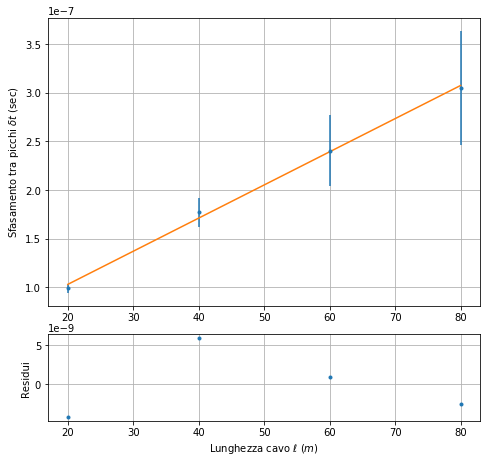

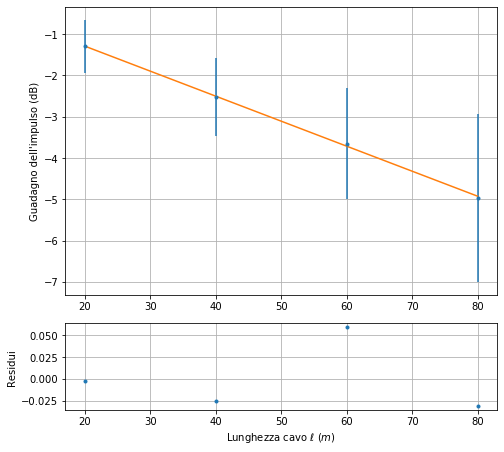

In [5]:
fig1=plt.figure()
ax1_1=fig1.add_axes([0,.4,1,1], label='plots')
ax1_2=fig1.add_axes([0,0,1,.3], label='residuals')
ax1_1.grid()
ax1_2.grid()
ax1_1.set_ylabel('Sfasamento tra picchi $\delta t$ (sec)')
ax1_1.errorbar(datadf['length'], datadf['deltat_avg'], yerr=datadf['deltat_err'], marker='.', fmt=' ')
ax1_1.plot(datadf['length'], linf(datadf['length'],*popt1))
ax1_2.plot(datadf['length'], datadf['deltat_avg']-linf(datadf['length'],*popt1),'.')
ax1_2.set_xlabel('Lunghezza cavo $\ell$ ($m$)')
ax1_2.set_ylabel('Residui')
fig2=plt.figure()
ax2_1=fig2.add_axes([0,.4,1,1], label='plots')
ax2_2=fig2.add_axes([0,0,1,.3], label='residuals')
ax2_1.grid(which='both')
ax2_2.grid()
#ax2_1.set_yscale('log')
ax2_1.set_ylabel('Guadagno dell\'impulso (dB)')
ax2_1.errorbar(datadf['length'], datadf['gain_db'], yerr=datadf['gain_dberr'], marker='.', fmt=' ')
ax2_1.plot(datadf['length'], linf(datadf['length'],*popt2))
ax2_2.plot(datadf['length'], datadf['gain_db']-linf(datadf['length'],*popt2),'.')
ax2_2.set_xlabel('Lunghezza cavo $\ell$ ($m$)')
ax2_2.set_ylabel('Residui')
m1=popt1[0]
m1err=np.sqrt(np.diag(pcov1))[0]
q1=popt1[1]
q1err=np.sqrt(np.diag(pcov1))[1]
m2=popt2[0]
m2err=np.sqrt(np.diag(pcov2))[0]
q2=popt2[1]
q2err=np.sqrt(np.diag(pcov2))[1]
print('I parametri del fit lineare n. 1 sono m = (%E+-%E) sec/m e q = (%E+-%E) sec'%(m1, m1err, q1, q1err))
print('I parametri del fit lineare n. 2 sono m = (%E+-%E) dB m^-1 e q = (%E+-%E) dB' % (m2, m2err, q2, q2err))
print('La velocità della luce è (%.3E +- %.3E), e quindi n = (%.3E +- %.3E)' % (m1**-1, m1err, constants.c*m1, m1err*constants.c))

Otteniamo i seguenti valori che ci interessano:

$$v^{-1}_{\text{exp}}=(3.4 \pm 0.1) \text{ sec m}^{-1} $$

$$n_{\text{exp}}=(1.02 \pm 0.04) $$

Inoltre l'attenuazione del cavo coassiale è

$$A^V_{\text{exp} } = (-6.060 \pm 0.001) \text{ dB m}^{-1} $$

Qui è tutta roba che riguarda **pyplot**, di cui vi consiglio di leggervi la [documentazione](https://matplotlib.org/3.1.1/users/index.html). Ci sono anche un sacco di [tutorial](https://matplotlib.org/3.1.1/tutorials/index.html#introductory) carini, così potete orientarvi. Nonostante i comandi più semplici possano sembrare banali, in realtà pyplot è potentissimo. Ad esempio qui si usa un paradigma ad oggetti, per cui definisco una figura, poi vi aggiungo due assi con dimensioni definite su cui dico poi di plottare determinate cose, attraverso l'uso delle `axes`. Un altro strumento importante sono i `subplot`s, che si possono usare, ad esempio, quando ho degli esperimenti ripetuti che mi danno risultati diversi, anche con griglie di 20 plot diversi nella stessa figura.

## Analisi Dati: Riflessione

Non vi ripeto le cose che ho detto prima. Qui seleziono i dati, li sposto rispetto al loro valore iniziale, poi enucleo i dati che non mi interessano (più o meno ho tolto quei dati che rientrano tra $-0.04V$ e $0.04V$). Uso il valore assoluto perché la mia funzione `find_peaks` trova solo i massimi. Quando vi applico `find_peaks` però ottengo anche alcuni vettori da **tre** valori. *Che succede qui?*

![](example2.png)

In pratica sono i valori di minimo che compaiono in quelle cuneette strane che vanno un po' in su e un po' in giù. Allora preferisco, in questo caso, trovare il valore medio tra gli ultimi due valori dell'array: definisco dunque un condizionale che, se trova array lunghi tre valori, allora mi media gli ultimi due risultati.

La funzione `range` permette di definire array che vanno dal primo parametro, strettamente minori del secondo parametro e spaziati del terzo parametro.

**Cosa sono popt e pcov?** La funzione `curve_fit`, che permette di fare i fit lineari e generalizzati, restituisce due cose:

- `popt`, che è un vettore che contiene tutti i parametri nell'ordine in cui sono definiti nella definizione della funzione nella prima cella
- `pcov`, che è una matrice che contiene le covarianze di un parametro rispetto all'altro; va da sè che sulla diagonale abbiamo le varianze, quindi è possibile ottenere l'array degli errori sui parametri semplicemente facendo `np.sqrt(np.diag(pcov))`

**Perché ci sono quegli asterischi prima di _popt_ e _pcov_?** Gli asterischi prima di un vettore (i.e. `*popt` per il vettore `popt`) non indicano un puntatore bensì uno _spacchettamento_. Ad esempio, se abbiamo il vettore `a = [12.542, 25.464, 7.152]`, `*a` ci darà non `array[12.542, 25.464, 7.152]`, bensì `12.542 25.464 7.152`. Sono quindi tre floats invece che un array di tre floats.

Chi quadrato per modello e osservazioni: 8.134090.
Studiamo se il chi quadro è nel range [2.603222, 26.756849]
Test del chi quadro superato!
Il parametro Z0 = (-61+-2) Ohm
Il test non è superato con un confidenza di 3 sigma


NameError: name 'popt3_1' is not defined

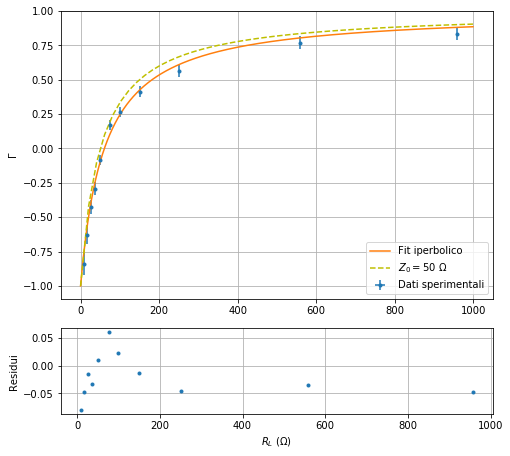

In [6]:
peak3=[]
peak4=[]
voltre=[]
r=[25.435,50.557,65.667,75.768,99.210,0.15050e3,0.25083e3,0.55787e3,0.95805e3, 3000,35.728,16.133,8.195]
dr=0.0001*np.asarray(r)+0.004
dr = np.delete(dr, [2,9])
for i in range(0,13):
    settings_file = f'data/refl{i}_1.txt'
    with open(settings_file, 'r') as f:
        scale_V = int(f.read().split('Scale ')[1].split('mV/,')[0])*1e-3
        delta_V = 8*scale_V*3e-2
    for j in range(0,4):
        file_name=f'data/refl{i}_{j}.csv'
        dfr=pd.read_csv(file_name, skiprows=[0]).dropna()
        dfr['Volt']=dfr['Volt']-dfr['Volt'][0]
        dfr['Volt']=dfr['Volt'][abs(dfr['Volt'])>.04]
        pk3, pkp3=signal.find_peaks(abs(dfr['Volt']))
        peak3.append(dfr['Volt'][pk3[0]])
        #plt.figure()
        #plt.plot(dfr['Volt'])
        #plt.scatter(pk3, dfr['Volt'][pk3], marker='x')
        #peak4.append(dfr['Volt'][pk3[1]])
        if(pk3.__len__()==3):
            peak4.append(dfr['Volt'][pk3[2]]+dfr['Volt'][pk3[1]])
        else:
            peak4.append(dfr['Volt'][pk3[1]])
        voltre.append(delta_V)
peak3=np.reshape(peak3, (13,4))
peak4=np.reshape(peak4, (13,4))
voltre=np.reshape(voltre, (13,4)).mean(axis=1)
gammaerr = abs(np.sqrt(np.power(np.sqrt(np.power(peak3.std(axis=1),2)+np.power(voltre,2))/peak3.mean(axis=1),2)+np.power(np.sqrt(np.power(peak4.std(axis=1),2) + np.power(voltre,2))/peak4.mean(axis=1),2))*peak4.mean(axis=1)/peak3.mean(axis=1))
refldict={'r': r,
          'gammaavg': peak4.mean(axis=1)/peak3.mean(axis=1),
          'gammaerr': gammaerr
}
rm=range(0,1000,1)
refldf=pd.DataFrame(refldict)
refldf=refldf.drop([9,2])
#refldf = refldf[(refldf['gammaavg'] < 0)]
popt3, pcov3=curve_fit(hpbf, refldf['r'], refldf['gammaavg'],sigma=refldf['gammaerr'])
##popt3_1, pcov3_1=curve_fit(hpbf, refldf['r'][5:], refldf['gammaavg'][5:],sigma=refldf['gammaerr'][5:])
fig3=plt.figure()
ax3_1=fig3.add_axes([0,.4,1,1], label='plots')
ax3_2=fig3.add_axes([0,0,1,.3], label='residuals')
ax3_1.grid()
ax3_2.grid()
ax3_1.set_ylabel('$\Gamma$')
ax3_1.errorbar(refldf['r'], refldf['gammaavg'], xerr=dr, yerr=refldf['gammaerr'], fmt=' ', marker='.', label='Dati sperimentali')
ax3_1.plot(rm, hpbf(rm,*popt3), label='Fit iperbolico')
#ax3_1.plot(rm,1*np.ones(1000),'g--')
#ax3_1.plot(rm, hpbf(rm,*popt3_1), label='Fit iperbolico per soli $R>100\,\Omega$')
ax3_1.plot(np.linspace(0,1000),hpbf(np.linspace(0,1000),-50), 'y--', label='$Z_0=50$ $\Omega$')
ax3_2.plot(refldf['r'], refldf['gammaavg']-hpbf(refldf['r'],*popt3),'.')
ax3_1.legend(loc='best')
ax3_2.set_xlabel('$R_L$ ($\Omega$)')
ax3_2.set_ylabel('Residui')
chiq3=chiq(hpbf(refldf['r'],*popt3), refldf['gammaavg'], refldf['gammaerr'])
testchiq(11,.005,.995, chiq3)
print('Il parametro Z0 = (%.0f+-%.0f) Ohm'%(*popt3,*np.sqrt(np.diag(pcov3))))
stattest(50,*popt3,0,*np.sqrt(np.diag(pcov3)),3)
#stattest(50,*popt3_1,0,*np.sqrt(np.diag(pcov3_1)),3)
display(*popt3_1, np.sqrt(np.diag(pcov3_1)))

Perfetto, il chi quadro torna ma non il test statistico ci dice che il nostro risultato non è compatibile con $50\,\Omega$! _E adés, sa fente?_ Proviamo con il calcolo dell'errore aposteriori... **NON FINITO**

In [ ]:
fig1.savefig('fig1.pdf', bbox_inches='tight')
fig2.savefig('fig2.pdf', bbox_inches='tight')
fig3.savefig('fig3.pdf', bbox_inches='tight')